In [2]:
import scipy.optimize as opt
import numpy as np

In [379]:
from __future__ import annotations
import numpy as np
from typing import *
import copy
from scipy.special import gammaln
import scipy.misc
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.optimize as opt
import os
import benchmark_functions as bf
from timeit import default_timer as timer

In [380]:
class MetricCollector:
    def __init__(self, name: str = None, run_id: int = None):
        self.name = name
        self.run_id = run_id

        self.best_individual_cost_each_gen = []
        self.avg_cost_each_gen = []

        self.best_elite_individual_cost_each_gen = []
        self.avg_elite_cost_each_gen = []

        self.best_middle_individual_cost_each_gen = []
        self.avg_middle_cost_each_gen = []

        self.best_lower_individual_cost_each_gen = []
        self.avg_lower_cost_each_gen = []
        self.iter_reached_vtr = -1
        self.nfev = 0
        self.time = -1

    def collect_all(self, best_individual_fitness: float, avg_fitness: float):
        self.best_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_cost_each_gen.append(avg_fitness)

    def collect_elite(self, best_individual_fitness: float, avg_fitness: float):
        self.best_elite_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_elite_cost_each_gen.append(avg_fitness)

    def collect_middle(self, best_individual_fitness: float, avg_fitness: float):
        self.best_middle_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_middle_cost_each_gen.append(avg_fitness)

    def collect_lower(self, best_individual_fitness: float, avg_fitness: float):
        self.best_lower_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_lower_cost_each_gen.append(avg_fitness)

    def compile_graphs(self):
        # make subplot for 4 graphs
        fig, axs = plt.subplots(2, 2)
        fig.suptitle('DE Metrics')
        xs = np.arange(len(self.best_individual_cost_each_gen))
        # plot best individual cost
        axs[0, 0].scatter(xs, self.best_individual_cost_each_gen, label="Best Individual", marker="x", s=1)
        axs[0, 0].scatter(xs, self.avg_cost_each_gen, label="Average", marker=".", s=1)
        axs[0, 0].set_title("All")
        axs[0, 0].legend()
        axs[0, 0].set_yscale('log')

        # plot best elite individual cost
        axs[0, 1].scatter(xs, self.best_elite_individual_cost_each_gen, label="Best Individual", marker="x", s=1)
        axs[0, 1].scatter(xs, self.avg_elite_cost_each_gen, label="Average", marker=".", s=1)
        axs[0, 1].set_title("Elite")
        axs[0, 1].legend()
        # make above plot log scale
        axs[0, 1].set_yscale('log')

        # plot best middle individual cost
        axs[1, 0].scatter(xs, self.best_middle_individual_cost_each_gen, label="Best Individual", marker="x", s=1)
        axs[1, 0].scatter(xs, self.avg_middle_cost_each_gen, label="Average", marker=".", s=1)
        axs[1, 0].set_title("Middle")
        axs[1, 0].legend()
        axs[1, 0].set_yscale('log')

        # plot best lower individual cost
        axs[1, 1].scatter(xs, self.best_lower_individual_cost_each_gen, label="Best Individual", marker="x", s=1)
        axs[1, 1].scatter(xs, self.avg_lower_cost_each_gen, label="Average", marker=".", s=1)
        axs[1, 1].set_title("Lower")
        axs[1, 1].legend()
        axs[1, 1].set_yscale('log')
        # show the plot
        # increase plot size
        fig.set_size_inches(18.5, 10.5)
        plt.show()

        # save graphs
        path = f"results/de_da/{self.name}/"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        np.save(f"{path}cost.npy", self.best_individual_cost_each_gen)
        fig.savefig(f"{path}graph.png")


    def collect_iter_reach_vtr(self, i, nfev, time):
        self.iter_reached_vtr = i
        self.nfev = nfev
        self.time = time

    def save_results(self):
        path = f"results/de_da/{self.name}/{self.run_id}.txt"
        # save best individual cost, and iteration reached vtr, nfes to file
        # also create folder if not exist
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w") as f:
            f.write(f"{self.best_elite_individual_cost_each_gen[-1]}\n")
            f.write(f"{self.iter_reached_vtr}\n")
            f.write(f"{self.nfev}\n")
            f.write(f"{self.time}\n")



In [381]:
def bound_applier(
    x: np.ndarray,
    bounds: List[Tuple]
):
    bounded = np.zeros_like(x)
    for i in range(len(x)):
        bounded[i] = x[i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
    return bounded

def latin_hyper_cube_initializer(dimension: int, population_size: int, bounds: List[Tuple], seed: int = 0) -> np.ndarray:
    lsh_sampler = stats.qmc.LatinHypercube(d=dimension, seed=seed)
    sample = lsh_sampler.random(n=population_size)
    bounded = np.apply_along_axis(
        lambda x: bound_applier(x, bounds),
        1,
        sample
    )
    return bounded

In [382]:
def best_1_mutator(
    population: np.ndarray,
    differential_factor: float,
    i: int
):
    # select three indices from the population that is not equal to i
    j, k = 0, 0
    while j == i:
        j = np.random.randint(0, population.shape[0])
    while k == i or k == j:
        k = np.random.randint(0, population.shape[0])
    mutant_vector = population[0] + differential_factor * (population[j] - population[k])
    return mutant_vector

def best_2_mutator(
    population: np.ndarray,
    differential_factor: float,
    i: int
):
    # select three indices from the population that is not equal to i
    j, k, l, m = 0, 0, 0, 0
    while j == i:
        j = np.random.randint(0, population.shape[0])
    while k == i or k == j:
        k = np.random.randint(0, population.shape[0])
    while l == i or l == j or l == k:
        l = np.random.randint(0, population.shape[0])
    while m == i or m == j or m == k or m == l:
        m = np.random.randint(0, population.shape[0])
    mutant_vector = population[0] + differential_factor * (population[j] - population[k] + population[l] - population[m])
    return mutant_vector

def rand_1_bin_mutator(
    population: np.ndarray,
    differential_factor: float,
    i: int
):
    # select three indices from the population that is not equal to i
    j, k, l = 0, 0, 0
    while j == i:
        j = np.random.randint(0, population.shape[0])
    while k == i or k == j:
        k = np.random.randint(0, population.shape[0])
    while l == i or l == j or l == k:
        l = np.random.randint(0, population.shape[0])
    mutant_vector = population[j] + differential_factor * (population[k] - population[l])
    return mutant_vector

def rand_2_bin_mutator(
    population: np.ndarray,
    differential_factor: float,
    i: int
):
    # select three indices from the population that is not equal to i
    j, k, l, m, n = 0, 0, 0, 0, 0
    while j == i:
        j = np.random.randint(0, population.shape[0])
    while k == i or k == j:
        k = np.random.randint(0, population.shape[0])
    while l == i or l == j or l == k:
        l = np.random.randint(0, population.shape[0])
    while m == i or m == j or m == k or m == l:
        m = np.random.randint(0, population.shape[0])
    while n == i or n == j or n == k or n == l or n == m:
        n = np.random.randint(0, population.shape[0])
    mutant_vector = population[j] + differential_factor * (population[k] - population[l] + population[m] - population[n])
    return mutant_vector

def binomial_crossover(
    target_vector: np.ndarray,
    mutant_vector: np.ndarray,
    crossover_prob: float
):
    trial = np.copy(target_vector)
    fill_point = np.random.randint(0, target_vector.shape[0])
    crossovers = np.random.uniform(size=target_vector.shape)
    crossovers = crossovers < crossover_prob
    crossovers[fill_point] = True
    trial = np.where(crossovers, mutant_vector, trial)
    return trial

In [383]:
def latin(sampler, n: int, bounds: List[Tuple]):
    sample = sampler.random(n=n)
    bounded = np.apply_along_axis(
        lambda x: bound_applier(x, bounds),
        1,
        sample
    )
    return bounded

def enforce_bounds(
    x: np.ndarray,
    bounds: List[Tuple]
):
    x_copy = copy.deepcopy(x)
    for i in range(len(x)):
        if x[i] < bounds[i][0]:
            x_copy[i] = bounds[i][0]
        elif x[i] > bounds[i][1]:
            x_copy[i] = bounds[i][1]
    return x_copy

In [384]:
def de_da(
    f: Callable,
    pop_initializer: Callable[[int], np.ndarray],
    bounds: List[Tuple],
    popsize: int,
    mutation_methods: List[Callable] = [rand_1_bin_mutator, best_1_mutator],
    mutation_methods_prob: List[float] = [2/3, 1/3],
    differential_factor: float = 0.5,
    crossover_prob: float = 0.01,
    elitism_ratio: float = 0.8,
    T: float = 5000.,
    visit: float = 2.62,
    accept: float = -5,
    max_explore_nodes: int = 0,
    iter_to_explore: int = 10,
    exact_gradient_prob: float = 0,
    gradient_cooldown_iter: int = 100,
    n_iter: int = 1000,
    vtr: float = 10e-8,
    metric: MetricCollector = MetricCollector(),
    seed: int = 0
):
    np.random.seed(seed)

    start = timer()
    nfev = 0
    collected_vtr = False

    def f_stub(x):
        nonlocal nfev
        nfev += 1
        return f(x)

    pop = pop_initializer(popsize)
    pop_val = np.apply_along_axis(f_stub, 1, pop)

    best = np.argmin(pop_val)
    best_val = pop_val[best]

    elitism_amount = int(popsize * elitism_ratio)
    gradient_cooldown = [0 for _ in range(popsize)]

    explore_nodes = []

    T_initial = T
    t1 = np.exp((visit - 1) * np.log(2.0)) - 1.0
    for i in range(n_iter):
        t2 = np.exp((visit - 1) * np.log(float(i) + 2)) - 1.0
        T = T_initial * (t1 / t2)

        if pop_val[0] < vtr and not collected_vtr:
            end = timer()
            metric.collect_iter_reach_vtr(i, nfev, end - start)
            collected_vtr = True

        if i % 100 == 0:
            print(f"Iteration {i}: Best: {best_val}, T: {T}, {pop_val}")

        chosen_mutation_methods = np.random.choice(mutation_methods, size=popsize, p=mutation_methods_prob)

        for j in range(popsize):
            target_vector = pop[j]
            mutant_vector = chosen_mutation_methods[j](pop, differential_factor, j)
            mutant_vector = binomial_crossover(target_vector, mutant_vector, crossover_prob)
            if gradient_cooldown[j] < i and np.random.rand() < exact_gradient_prob:
                mutant_vector = opt.minimize(f_stub, target_vector, method="BFGS", options={"maxiter": 10}).x
                gradient_cooldown[j] = i + gradient_cooldown_iter
                if len(explore_nodes) < max_explore_nodes and T > 0.:
                    explore_nodes.append((mutant_vector.copy(), i + iter_to_explore))

            mutant_vector = enforce_bounds(mutant_vector, bounds)

            # feasible, check if better
            mutant_val = f_stub(mutant_vector)
            delta = mutant_val - pop_val[j]

            if delta < 0:
                pop[j] = mutant_vector
                pop_val[j] = mutant_val

                if pop_val[j] < pop_val[0]:
                    pop[0], pop[j] = pop[j], pop[0]
                    pop_val[0], pop_val[j] = pop_val[j], pop_val[0]
                    gradient_cooldown[0], gradient_cooldown[j] = gradient_cooldown[j], gradient_cooldown[0]
            elif T > 0 and j > elitism_amount:
                pqv_temp = 1.0 - ((1.0 - accept) * delta / T)
                if pqv_temp <= 0.:
                    pqv = 0.
                else:
                    pqv = np.exp(np.log(pqv_temp) / (1. - accept))
                if np.random.rand() < pqv:
                    # sa accept
                    pop[j] = mutant_vector
                    pop_val[j] = mutant_val

        next_gen_explore_nodes = []

        if T > 0.:
            for node in explore_nodes:
                x, to_iter_i = node
                if i < to_iter_i:
                    # do da
                    da_res = opt.dual_annealing(
                        f_stub,
                        bounds=bounds,
                        maxiter=1,
                        no_local_search=True,
                        x0=x,
                        initial_temp=T,
                        visit=visit,
                        accept=accept
                    )
                    next_gen_explore_nodes.append((da_res.x, to_iter_i))
                else:
                    minimized = opt.minimize(f_stub, x, method="BFGS", options={"maxiter": 10})
                    rand_j = np.random.randint(1, popsize)
                    delta = minimized.fun - pop_val[rand_j]
                    if delta < 0:
                        pop[rand_j] = minimized.x
                        pop_val[rand_j] = minimized.fun
                    elif T > 0 and (delta / T < 10e-10):
                        pqv_temp = 1.0 - ((1.0 - accept) * delta / T)
                        if pqv_temp <= 0.:
                            pqv = 0.
                        else:
                            pqv = np.exp(np.log(pqv_temp) / (1. - accept))
                        if np.random.rand() < pqv:
                            pop[rand_j] = minimized.x
                            pop_val[rand_j] = minimized.fun

        explore_nodes = next_gen_explore_nodes

        if pop_val[0] <= best_val:
            best_val = pop_val[0]

        metric.collect_all(best_val, np.mean(pop_val))
        metric.collect_elite(best_val, np.mean(pop_val))
        metric.collect_middle(np.min(best_val), np.mean(pop_val))
        metric.collect_lower(np.min(best_val), np.mean(pop_val))

    if not collected_vtr:
        metric.collect_iter_reach_vtr(n_iter, nfev, timer() - start)

    best_index = np.argmin(np.apply_along_axis(f, 1, pop))
    best = pop[best_index]
    best_val = f(best)
    print(pop_val)
    print(gradient_cooldown)
    return best, best_val

Iteration 0: Best: 65660.2504606203, T: 0.0, [ 76148.64988479  89567.53336119  93689.59799164 104034.39602406
 109728.82947566 152050.17778281 105145.35637665  88175.21492193
  94784.04129811 111697.20093096  94173.92540291  94699.55737394
  92187.0326682   98721.085202   103283.26056409 123570.10469362
  85586.97766863 104975.38787141  84691.24974082 101409.59996326
 112664.70961041  86042.11993991  86104.44727525 110905.19489379
  97144.89986332  83247.17228756  90370.13468541 101435.66773384
  96058.48574782 114831.990789    89972.39956764 110217.95339629
  84882.85181072 113576.43983439  94068.0681368  130655.75847241
  94736.80567956  65660.25046062 119339.65094146 115472.43219366]
Iteration 100: Best: 3.1600186840990433e-16, T: 0.0, [3.16001868e-16 5.52127338e-16 4.27686786e-16 3.22333702e-16
 3.52767099e-16 3.81638328e-16 4.33213333e-16 4.14032488e-16
 3.37396367e-16 4.16248302e-16 3.16788684e-16 4.54280937e-16
 3.64517539e-16 4.84544147e-16 4.12916543e-16 3.16592894e-16
 3.2291

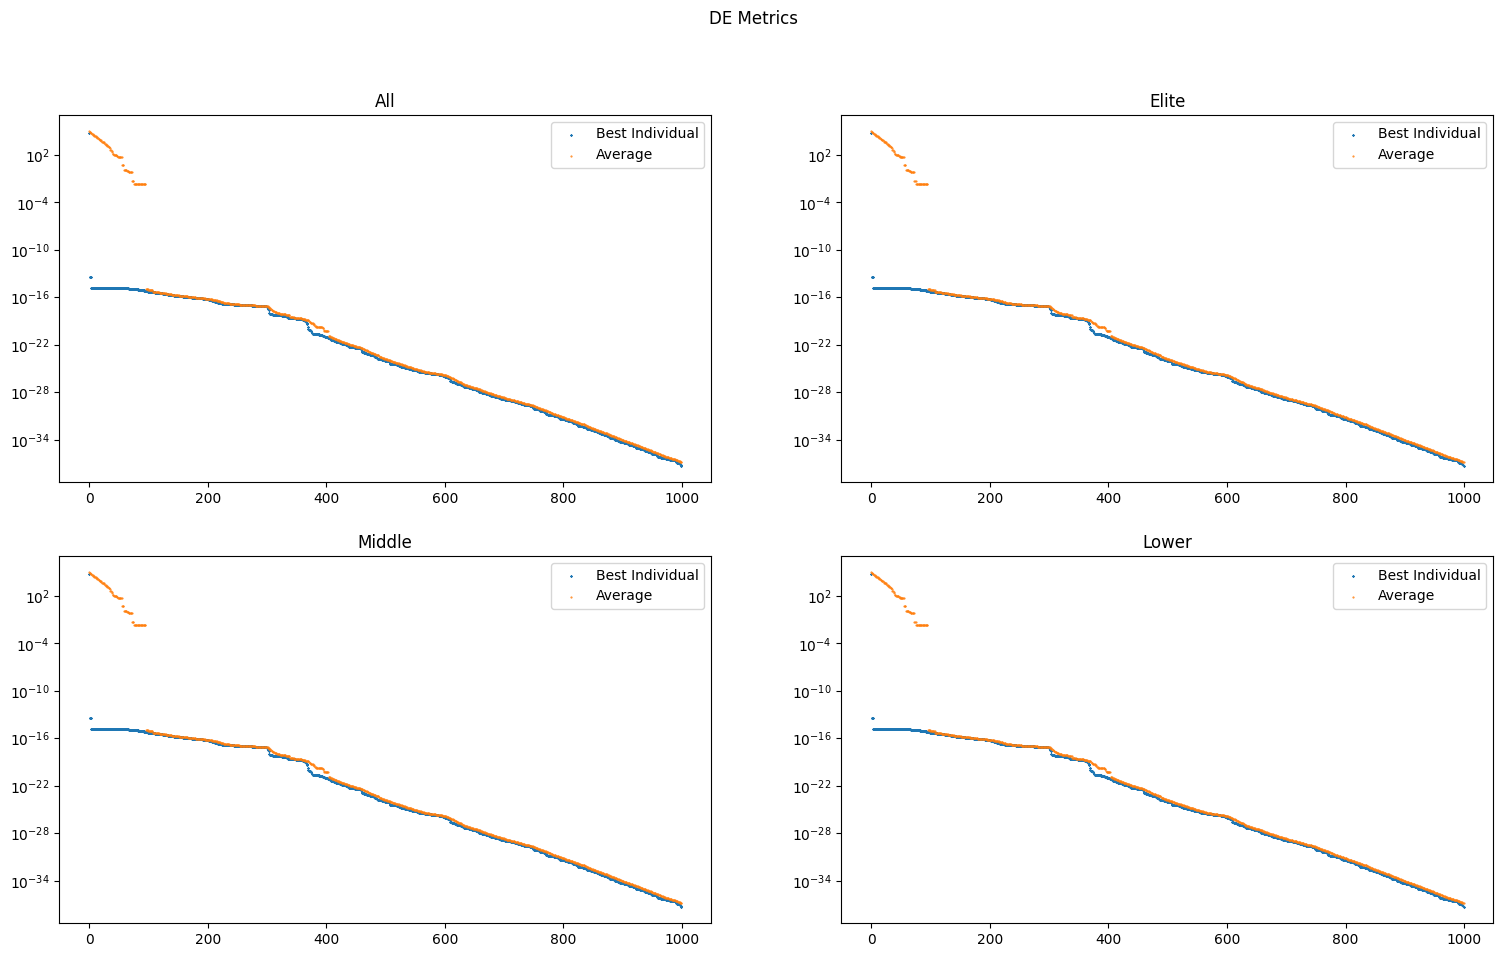

(array([ 7.47199288e-20,  9.90641793e-21,  1.53851530e-20,  6.71520208e-20,
         8.14489616e-20, -4.26251773e-20, -9.76716333e-21,  2.04830149e-20,
        -3.28014503e-20, -4.11868157e-20,  6.96529700e-20, -5.52121029e-21,
        -9.45133753e-21,  9.13773474e-20,  2.89682697e-20,  2.53767254e-20,
        -3.23542881e-20, -2.38518443e-20,  2.83552342e-20, -2.65740246e-20,
        -7.28817580e-20, -2.53629227e-20,  3.90165347e-20, -5.47546297e-21,
         2.17766734e-20, -1.02101068e-20, -8.42380071e-21,  3.03354842e-21,
        -5.21276258e-20,  2.95446286e-20]),
 5.185170209231519e-38)

In [386]:
def sphere(x: np.ndarray):
    return np.sum(np.apply_along_axis(lambda y: (y)**2, 0, x))

for i in range(30):
    metric_1 = MetricCollector(name="sphere", run_id=i)
    popsize = 40
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    n_iters = 1000

    res = de_da(
        f=sphere,
        popsize=popsize,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        bounds=bounds,
        exact_gradient_prob=0.01,
        differential_factor=0.3,
        crossover_prob=0.1,
        n_iter=n_iters,
        metric=metric_1,
        T=0,
        elitism_ratio=1,
        seed=i
    )
    metric_1.save_results()
    print(res[0].astype(str))

metric_1.compile_graphs()
res


Iteration 0: Best: 967450.9299453411, T: 0.0, [1069759.97008004 1458557.31562308 1324013.30024187 1419645.63513024
 1657867.92881404 2408788.7834869  1794643.83152071 1239851.17778716
 1633018.09267315 1698600.70237459 1405637.32061649 1401258.8315127
 1418591.13274623 1611176.04801699 1537885.05645451 1992443.46132914
 1320316.93997022 1615344.64635933 1064381.71256001 1726432.74680819
 1784794.29465146 1380478.20741425 1104957.07076264 1543993.01468764
 1534748.15053458 1314947.80852014 1536886.62689202 1497498.06094596
 1555269.01312858 2041357.53777786 1297166.37476383 1801794.71061153
 1351187.12186521 1625241.22998733 1492267.09225458 2245722.59224735
 1740276.43221791  967450.92994534 1655237.77929985 1761762.5790161 ]
Iteration 100: Best: 0.028037342344649042, T: 0.0, [0.02803734 1.4211779  2.15081755 1.02412096 1.17939601 0.70153756
 2.28278844 1.39411682 0.60023687 0.45580603 0.80039089 1.45355923
 0.3291922  0.39515137 0.53590834 0.47301523 1.58345821 1.06320675
 1.02593054 

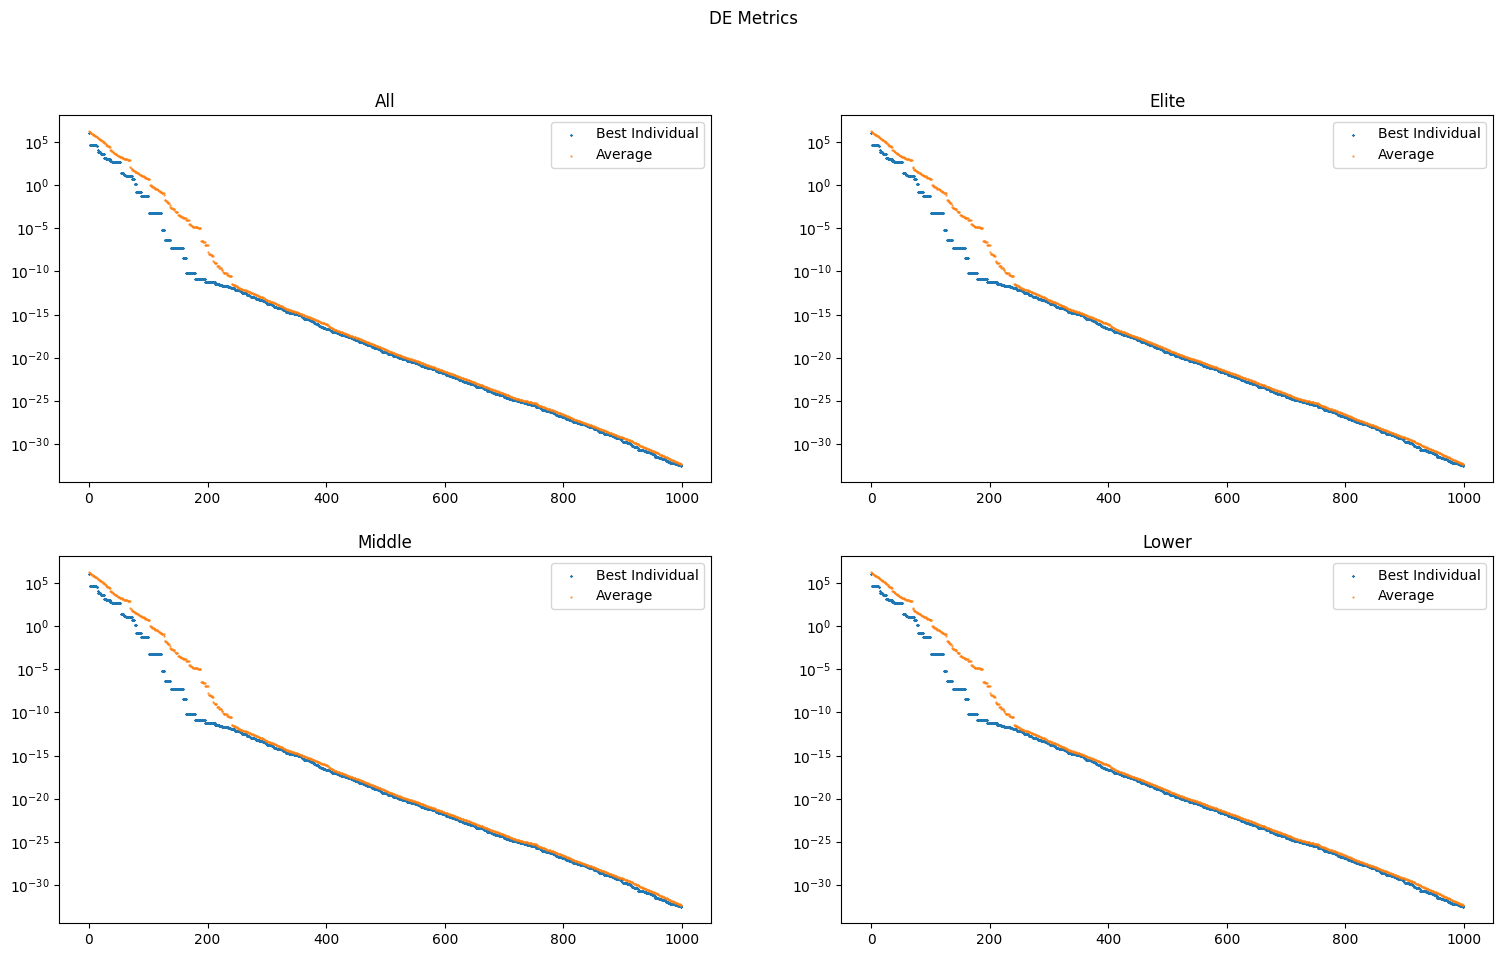

(array([-1.59011738e-17,  3.72519991e-18, -1.61436396e-18, -4.27800462e-18,
         1.24542474e-18,  5.60506398e-18, -1.65458240e-18, -4.11330396e-18,
         4.65103114e-18, -4.64940083e-19,  8.05183461e-19,  4.63902989e-18,
         1.35630808e-18,  1.03317099e-19,  6.01672451e-18, -2.44328893e-18,
        -3.19012434e-18,  6.00739421e-19,  8.88894442e-19, -2.47561381e-18,
         1.08581188e-18,  5.12626470e-19,  7.77543790e-19, -1.21010340e-18,
        -5.00224213e-19, -4.63507750e-18,  2.48264338e-18, -1.61603309e-18,
         1.02106638e-19,  4.48791031e-18]),
 3.6428191747875254e-33)

In [387]:
def weighted_sphere(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += (i + 1) * (x[i]) ** 2
    return cost

for i in range(30):
    metric_weighted_sphere = MetricCollector(name="weighted_sphere", run_id=i)
    popsize = 40
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = de_da(
        f=weighted_sphere,
        popsize=popsize,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        bounds=bounds,
        exact_gradient_prob=0.01,
        differential_factor=0.4,
        crossover_prob=0.1,
        n_iter=n_iters,
        metric=metric_weighted_sphere,
        T=0,
        seed=i
    )
    metric_weighted_sphere.save_results()
metric_weighted_sphere.compile_graphs()
res

Iteration 0: Best: 127741.29003138797, T: 0.0, [ 653055.22369908 2051488.6718055  1823373.11037989  990893.13288329
 2379454.72283048 1321481.66649368 1797266.48852556  506401.10737885
 1547651.1099151   621499.76188438  597606.76725669 2489530.05340711
  495156.43734092  322754.99479235  385751.76498448  490153.63981249
  127741.29003139  540719.43440686  617310.43535991  713400.11932047
  977029.73280705  185963.92655493  161030.83313431 2284372.59584369
  690015.33849385 1111557.09595061 2008443.80582165  268419.91972881
 3270515.63363123  648408.64115826 2411386.76605032 8626830.12631319
  509187.76029061 1593514.03327274 4716300.83758233  810380.26846785
 1817245.83826229  178938.97822393  480307.30917745  604487.44962671]
Iteration 100: Best: 3.9616403084879604e-05, T: 0.0, [3.96164031e-05 3.27555766e-03 1.08646948e+00 2.11630438e+00
 9.82479021e-04 1.32361428e-01 3.65617247e-04 8.09569086e-02
 1.48716758e+00 8.83978029e-02 7.60052646e-01 3.37610428e+00
 1.31089845e-01 2.82492256

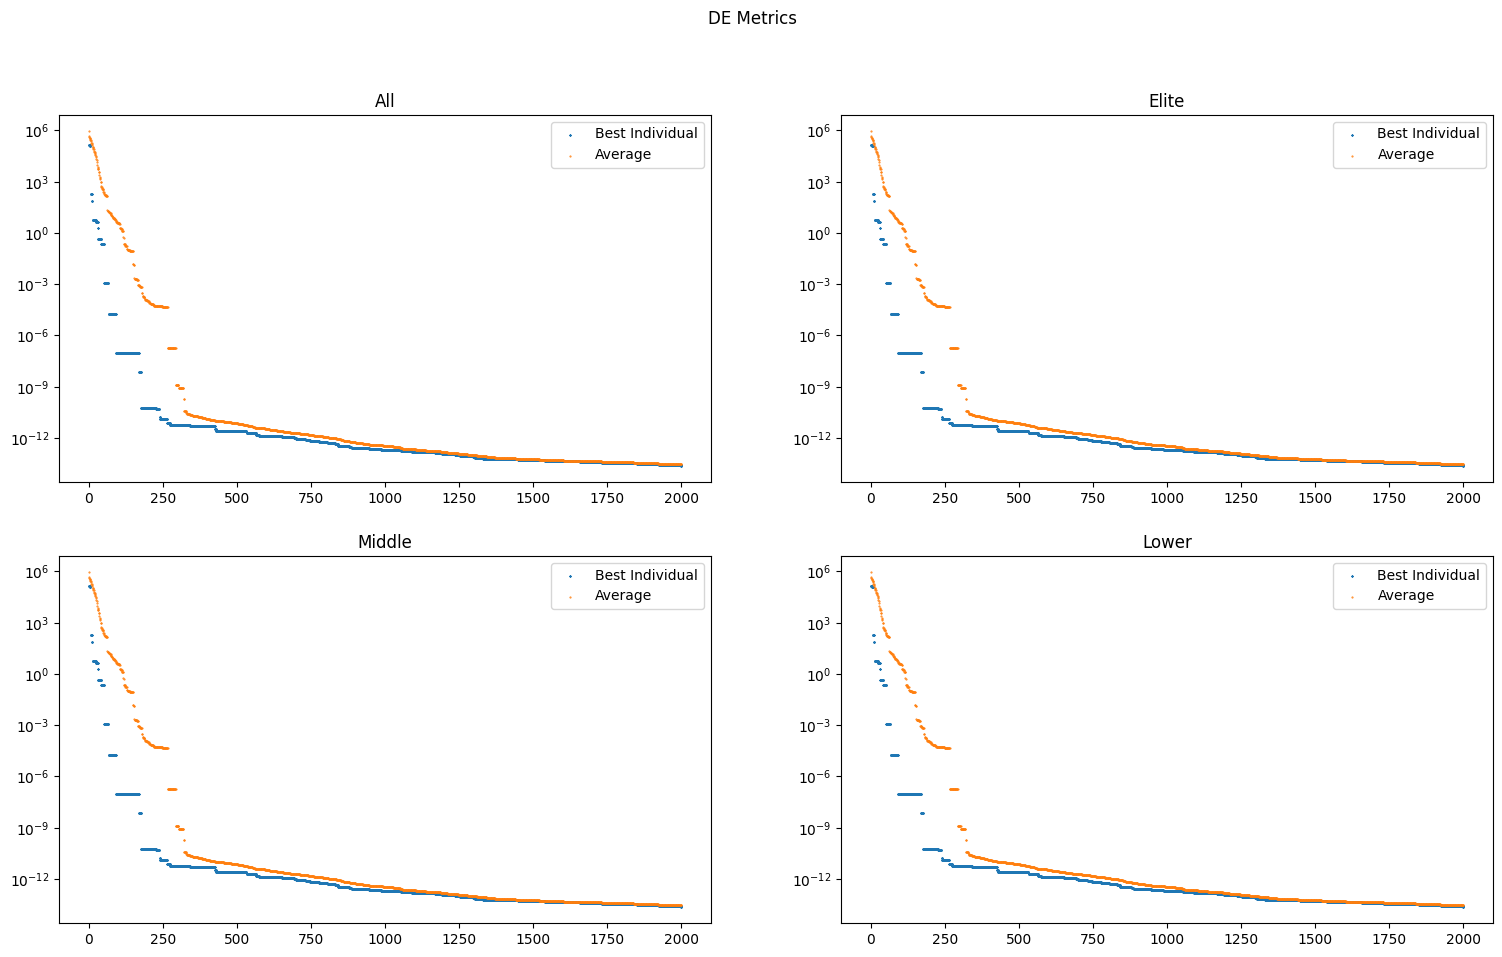

(array([ 4.52928723e+01, -4.52928723e+01,  1.12647901e-08, -7.83011998e-09,
         1.00347700e-08,  4.94920859e-08, -1.44032134e-07,  1.64221986e-07,
        -1.22773825e-07,  5.82119702e-08, -5.13750651e-09, -1.55146915e-08,
        -1.04543553e-08,  1.21649028e-08, -1.81774282e-08,  5.24608341e-08,
        -5.06281245e-09, -1.74156676e-08, -2.25172700e-08,  3.40647312e-08,
        -7.89054724e-09, -1.51713621e-08,  3.05088309e-09, -1.92859280e-08,
         1.48716649e-08, -6.12272190e-09,  1.49020441e-08, -2.81644967e-08,
         3.54291778e-08, -1.54916403e-08]),
 2.4296947456030482e-14)

In [388]:
def schwefel_1_2(x: np.ndarray):
    seq = np.arange(1, x.shape[0] + 1, dtype=int).reshape(x.shape[0], 1)
    cost = np.sum(np.apply_along_axis(lambda j: np.sum(x[:j[0] + 1]) ** 2, 1, seq))
    return cost

for i in range(30):
    metric_schwefel_1_2 = MetricCollector(name="schwefel_1_2", run_id=i)
    popsize = 40
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 2000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = de_da(
        f=schwefel_1_2,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_prob=0.01,
        differential_factor=0.5,
        crossover_prob=0.5,
        mutation_methods_prob=[1/2, 1/2],
        n_iter=n_iters,
        metric=metric_schwefel_1_2,
        T=0,
        elitism_ratio=1,
        gradient_cooldown_iter=20,
        max_explore_nodes=0,
        seed=i
    )
    metric_schwefel_1_2.save_results()
metric_schwefel_1_2.compile_graphs()
res

Iteration 0: Best: 10988.518109649915, T: 100.0, [13414.611604   12310.76529224 12382.76172475 11964.54760648
 12359.76403677 11195.7046503  11440.98865708 12599.17502941
 12589.88100834 14111.42843074 11510.04683671 12833.32683881
 12086.39421156 12924.27438485 14077.29262841 15580.35700331
 12195.42783139 11357.10020003 12160.74950165 13095.54556437
 12096.43731785 13255.33095005 12148.88094556 15147.19977178
 11929.95795737 12201.37652757 11756.36913198 13312.65093208
 11160.89840854 12034.5594826  13702.1041091  15137.03174381
 13559.27268762 11263.24890765 11391.4322897  11745.09459613
 11807.32043651 10988.51810965 11334.7703301  11963.11296833]
Iteration 100: Best: 1353.430109372266, T: 0.11562887083771374, [1353.43010937 2890.20193713 2302.07031051 2560.81014624 1974.26616596
 2269.52212747 2026.04613533 1689.27930674 2220.96977707 2263.52232567
 1922.04108799 2579.13381138 2461.73445347 2207.62699301 2016.1204988
 1788.37804391 2079.49397013 1819.50955823 2222.44122969 2663.65

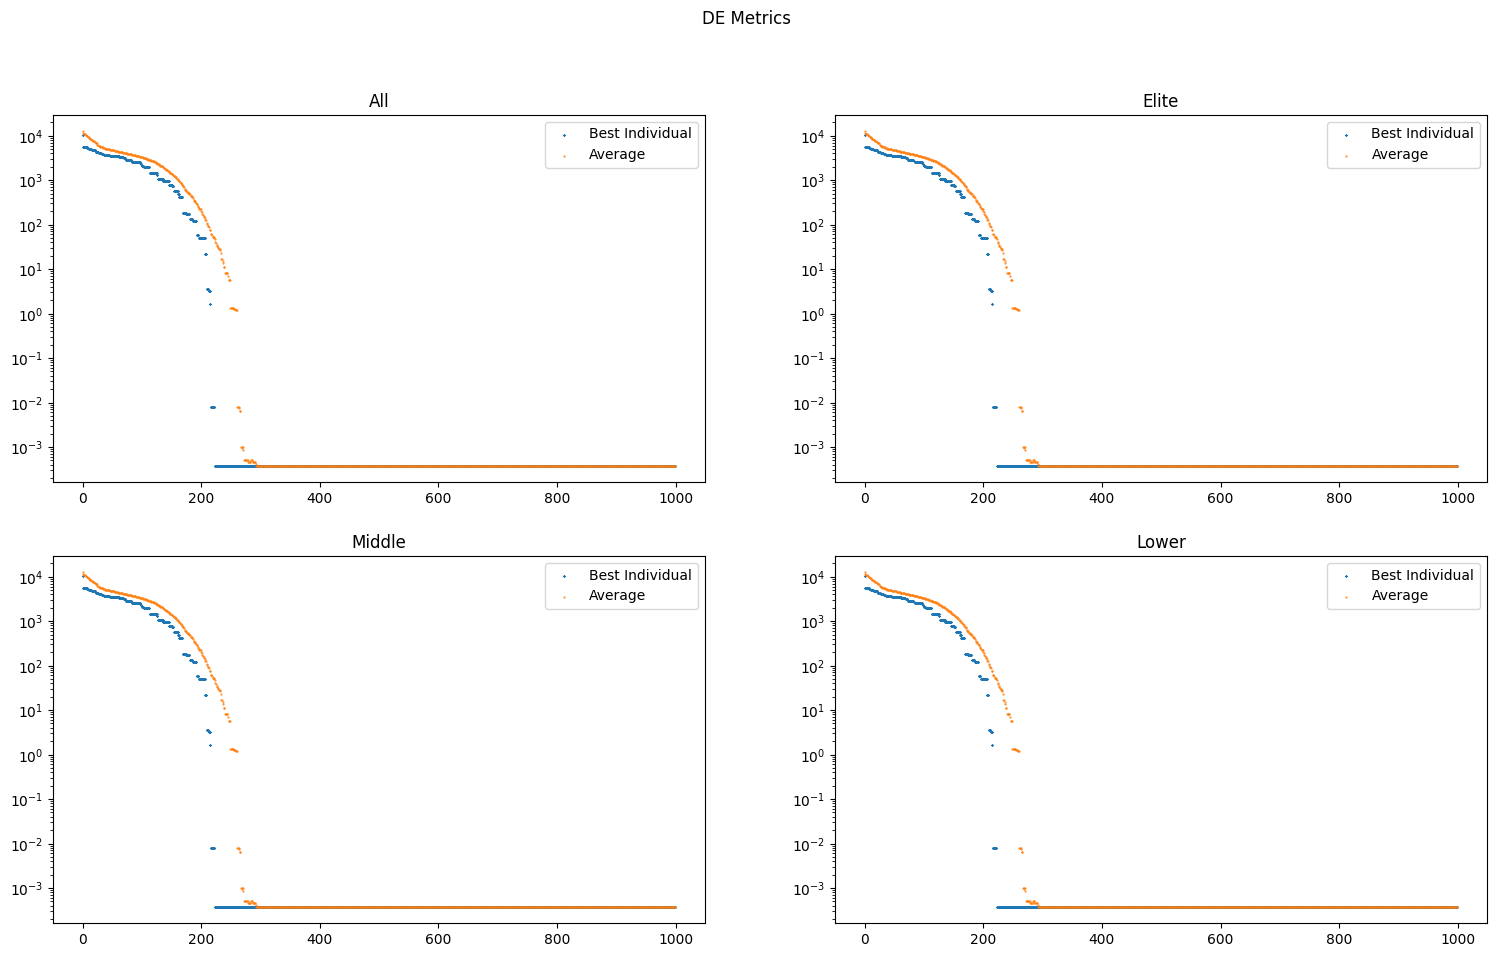

(array([420.96874629, 420.96874553, 420.96874849, 420.96874711,
        420.96874483, 420.96874774, 420.96874744, 420.96874437,
        420.96874788, 420.96874511, 420.96874783, 420.96874784,
        420.96874801, 420.96874691, 420.96874497, 420.96874433,
        420.96874782, 420.96874785, 420.96874861, 420.96874605,
        420.96874393, 420.96874641, 420.96874741, 420.96874698,
        420.96874401, 420.96874459, 420.96874868, 420.96874537,
        420.96874525, 420.96874709]),
 0.00038182699245226104)

In [389]:
def schwefel_2_3(x: np.ndarray):
    cost = 418.9829 * x.shape[0] - np.sum(np.apply_along_axis(lambda y: y * np.sin(np.sqrt(np.abs(y))), 0, x))
    return cost

for i in range(30):
    np.random.seed(i)
    metric_schwefel_2_3 = MetricCollector(name="schwefel_2_3", run_id=i)
    popsize = 40
    d = 30
    bounds = [(-500, 500) for _ in range(d)]
    n_iters = 1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = de_da(
        f=schwefel_2_3,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_prob=0.05,
        differential_factor=1,
        crossover_prob=0.1,
        n_iter=n_iters,
        T=100,
        elitism_ratio=0.8,
        metric=metric_schwefel_2_3,
        vtr=1,
        seed=i
    )
    metric_schwefel_2_3.save_results()
metric_schwefel_2_3.compile_graphs()
res

Iteration 0: Best: 1.0, T: 5000.0, [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Iteration 100: Best: 0.3101782815523767, T: 5.781443541885687, [0.31017828 0.7360633  1.         1.         0.99999944 0.99994205
 1.         1.         0.55889621 0.66124341 0.64195382 0.3148835
 0.48913777 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.54944625
 1.         0.67139211 1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.82886903
 1.         1.         1.         0.31017828]
Iteration 200: Best: 0.0, T: 1.9104570247626347, [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 300: Best: 0.0, T: 0.9957651834554854, [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iter

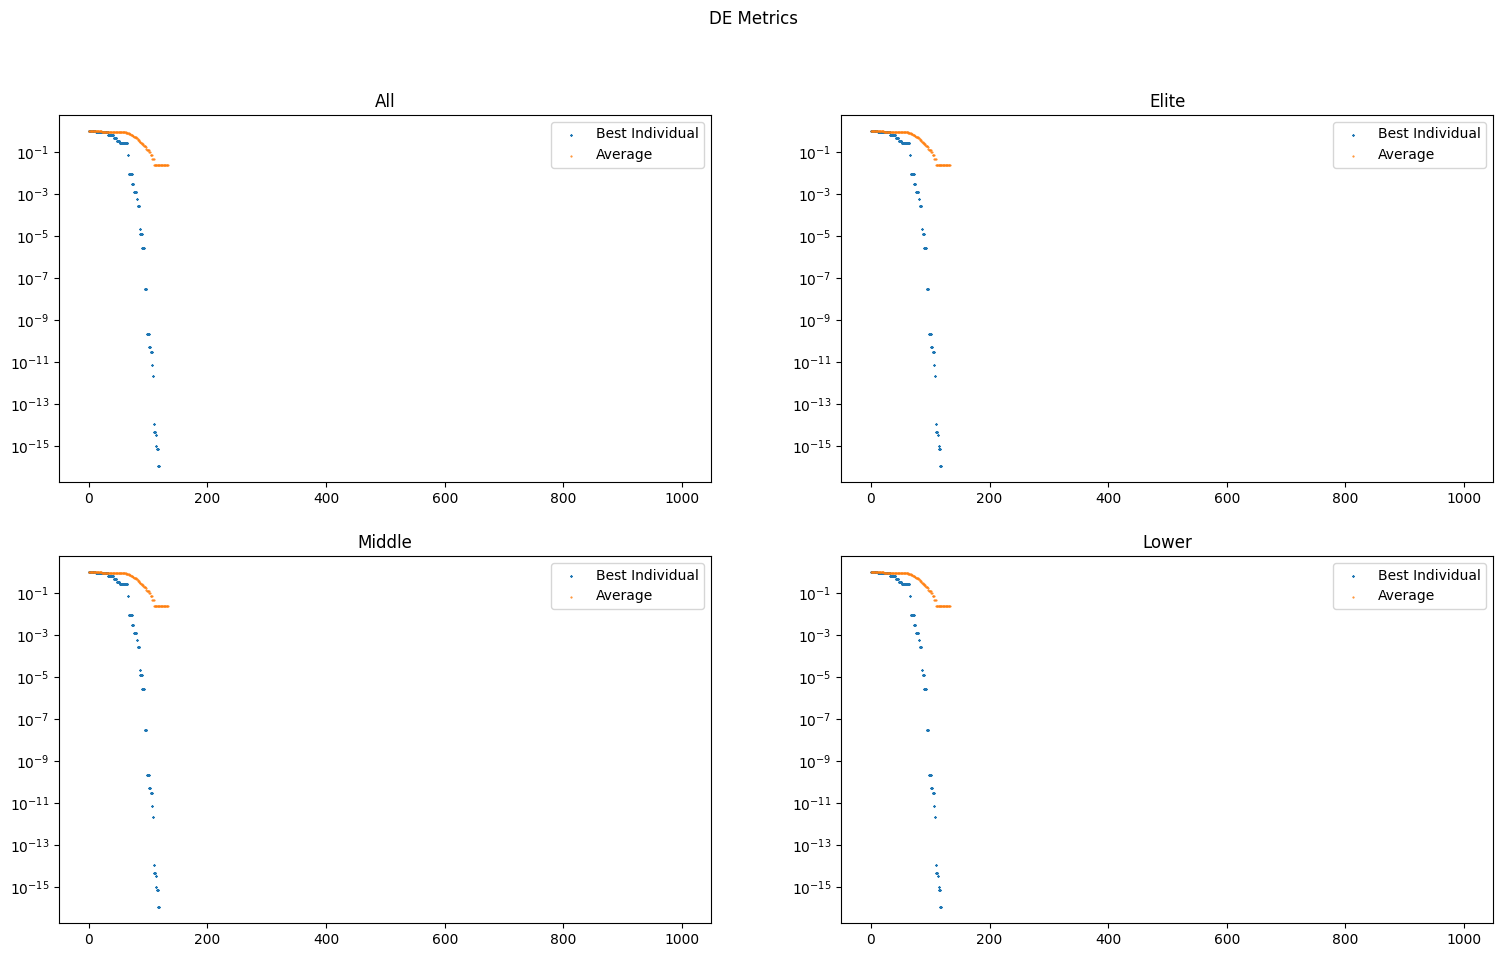

(array([3.14159266, 3.14159265]), 0.0)

In [390]:
for i in range(30):
    easom = lambda x: bf.Easom()(x) + 1
    np.random.seed(i)
    metric_easom = MetricCollector(name="easom", run_id=i)
    popsize = 40
    d = 2
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)

    res = de_da(
        f=easom,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_prob=0.0,
        differential_factor=0.5,
        crossover_prob=0.1,
        n_iter=n_iters,
        metric=metric_easom,
        elitism_ratio=1,
        seed=i
    )
    metric_easom.save_results()
metric_easom.compile_graphs()
res

Iteration 0: Best: 486545.57815452194, T: 0.0, [ 586811.8346852   604556.11893387  715363.58837548  816198.81681681
  795993.68476187 1052442.62567087  673807.71590719  678101.20025958
  600827.02189452  804967.21229771  688814.01522476  699604.42115802
  656228.0718313   664817.13466572  756408.63464958  840965.24040773
  608995.58087429  745658.01674861  706790.42229042  652143.43304749
  781716.33595962  588719.57612901  708304.47900944  859271.72486463
  672052.8820028   576361.14684388  581930.21790196  747541.52017712
  650271.94230213  699119.78064688  678129.32046192  740927.2099473
  585051.55202663  859328.13485555  651120.31420864  828612.5442774
  552383.26161798  486545.57815452  928409.31797136  829390.99437793]
Iteration 100: Best: 0.01360739010108924, T: 0.0, [ 0.01360739  6.37071239  1.2490104   0.99639433  1.41915786  3.39323799
 13.39986923  3.14994748  0.6882332   2.82234223  0.67353465  2.83916545
  0.38142831  2.89869149  2.01294391  0.82505781  2.34518599  1.2537

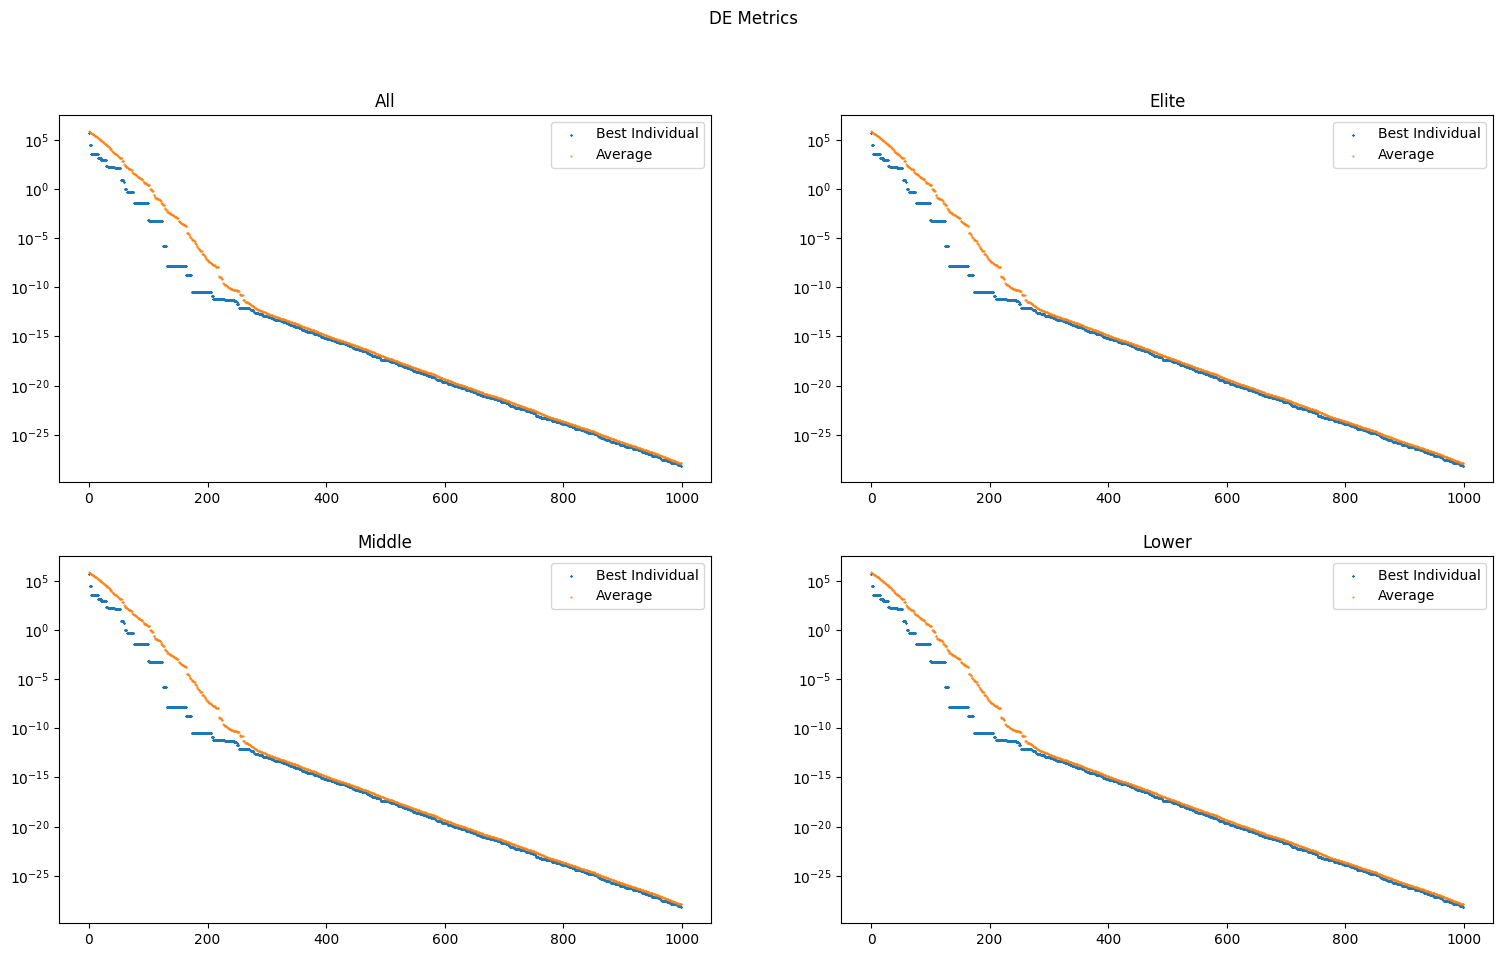

(array([ 1.13518161e-16, -1.79994693e-16,  3.21880862e-17, -6.10988765e-16,
         2.74860760e-16, -6.41268544e-16, -1.37126278e-16,  9.48454570e-17,
        -3.21718886e-16, -2.15052260e-16, -1.51364147e-17,  5.74339849e-16,
         3.69446126e-16,  2.91183815e-16, -1.81728888e-16, -3.42596428e-18,
        -8.22714472e-18, -4.31509459e-17,  2.31603651e-16,  9.37676067e-17,
         9.33346626e-16,  4.25869671e-17,  6.40905379e-16, -1.18406207e-16,
         2.77309506e-16, -1.16901145e-15,  3.33245722e-16, -1.26044165e-15,
         9.59732431e-16,  5.42132927e-16]),
 7.317867585134025e-29)

In [391]:
def rotated_hyper_ellipsoid(x: np.ndarray):
    # rotated hyper ellipsoid
    seq = np.arange(1, x.shape[0] + 1, dtype=int).reshape(x.shape[0], 1)
    cost = np.sum(np.apply_along_axis(lambda j: np.sum(x[:j[0] + 1] ** 2), 1, seq))
    return cost

for i in range(30):
    np.random.seed(i)
    metric_5 = MetricCollector(name="rotated_hyper_ellipsoid", run_id=i)
    bounds = [(-65.536, 65.536) for _ in range(30)]
    d = 30
    popsize = 40
    n_iters = 1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = de_da(
        f=rotated_hyper_ellipsoid,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_prob=0.01,
        differential_factor=0.5,
        crossover_prob=0.1,
        elitism_ratio=1,
        n_iter=n_iters,
        metric=metric_5,
        T=0,
        seed=i
    )
    metric_5.save_results()
metric_5.compile_graphs()
res

Iteration 0: Best: 7400.86336825752, T: 1000.0, [10601.5084733  17085.39878122 13512.96709615 18045.86484685
 18367.49048735 20298.47723895 13121.56968953 12313.87390839
 14868.46907614 17434.33171514 14617.79121588 11041.10618473
 14634.85391016 13218.53965184 14944.99742574 19489.42189577
  8867.95401014 14031.74968226 13629.49059983 15725.69305671
 17155.75042337 12092.11155683 13001.05168129 20791.96357819
 13680.20616943  8444.60108147 14192.70702407 12055.93697131
 11552.77046563 19235.01257969 12670.19936266 20166.88951098
 10542.52091032 11983.62174907 11831.84962327 21503.49123911
 10283.44957734  7400.86336826 20907.498092   17905.57195938]
Iteration 100: Best: 18.994537035459338, T: 1.1562887083771374, [ 18.99453704  24.04250754  22.61927579  46.83207684  83.4534942
  94.48472371  94.41741533  23.51865873  26.58114467  77.86589627
  79.10284035  41.76324162  26.84771804  65.57521936  29.02079277
  78.70948581  28.7235645   31.32955595  49.53557024  26.57018568
  29.18046866 

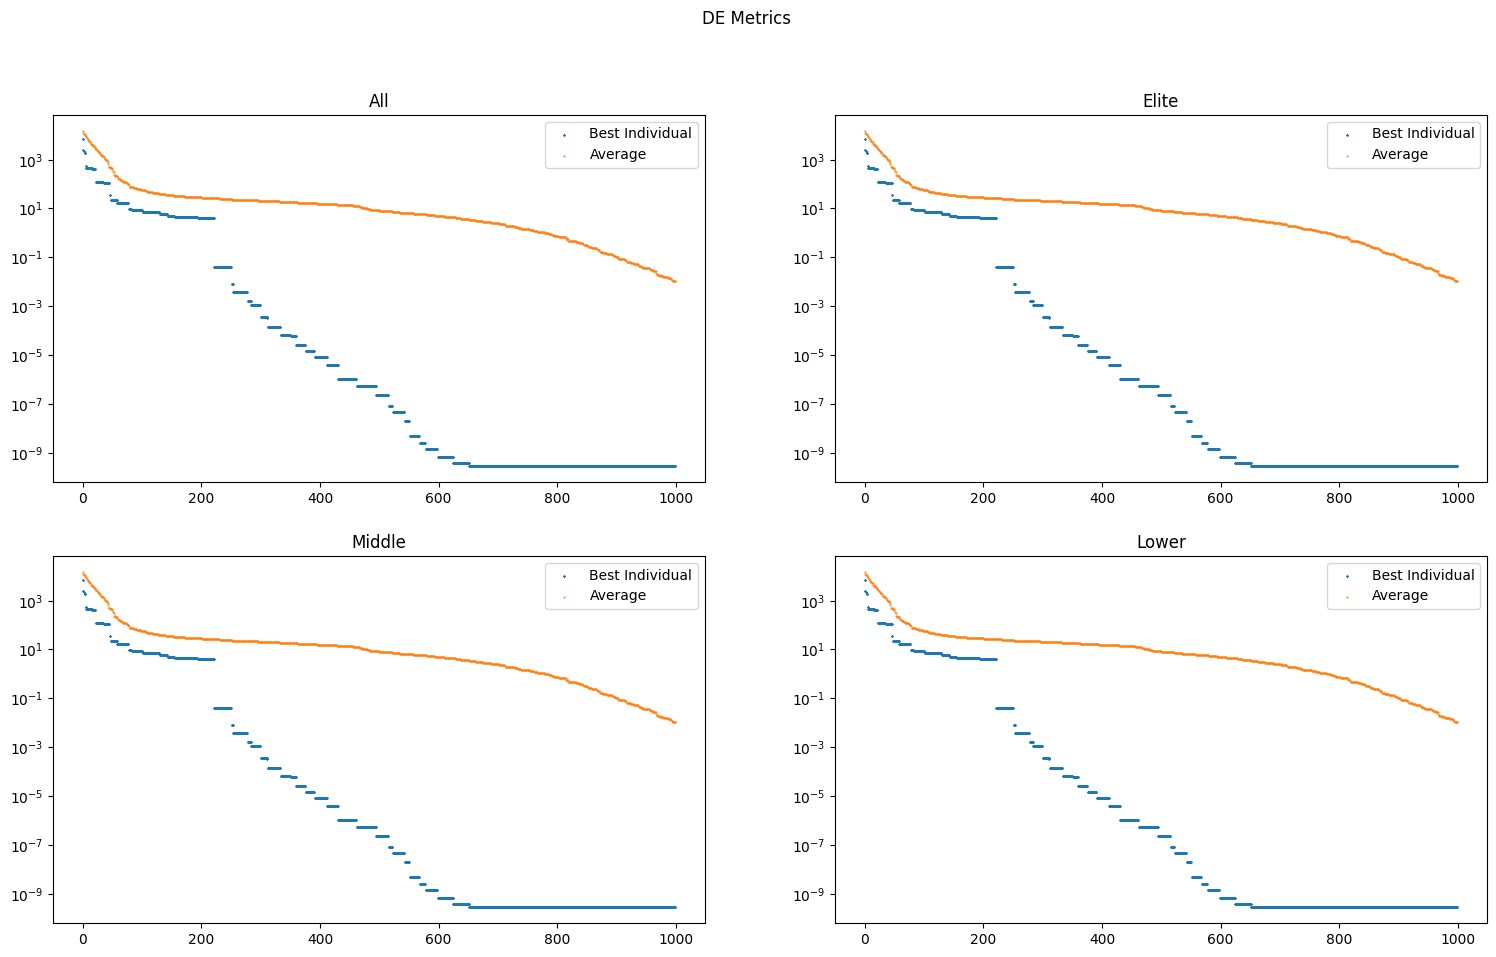

(array([0.99999981, 1.00000002, 0.99999989, 0.99999998, 0.99999999,
        0.99999996, 0.99999989, 1.00000007, 1.00000002, 1.00000009,
        0.99999989, 0.99999988, 1.00000012, 1.00000001, 1.00000001,
        0.99999995, 0.99999995, 0.99999986, 0.99999986, 0.99999998,
        0.99999991, 0.99999993, 0.99999983, 0.99999965, 0.99999935,
        0.99999869, 0.99999714, 0.99999443, 0.99998856, 0.99997767]),
 2.915369869601658e-10)

In [392]:
def rosenbrock(x: np.ndarray):
    # rosenbrock
    cost = 0
    for i in range(x.shape[0] - 1):
        cost += 100 * (x[i + 1] - x[i]**2)**2 + (x[i] - 1)**2
    return cost


for i in range(30):
    metric_rosen = MetricCollector(name="rosenbrock", run_id=i)
    bounds = [(-2.048, 2.048) for _ in range(30)]
    d = 30
    n_iters = 1000
    popsize = 40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = de_da(
        f=rosenbrock,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_prob=0.1,
        differential_factor=0.5,
        crossover_prob=0.01,
        n_iter=n_iters,
        metric=metric_rosen,
        T=1000,
        elitism_ratio=0.8,
        gradient_cooldown_iter=20,
        seed=i
    )
    metric_rosen.save_results()
metric_rosen.compile_graphs()
res

Iteration 0: Best: 591.9422542313703, T: 5000.0, [ 686.33784959  807.10781453  844.20638193  937.30956422  988.55946529
 1369.45160034  947.30820741  794.5769343   854.05637168 1006.27480838
  848.56532866  853.29601637  830.68329517  889.48976682  930.54934508
 1113.13094224  771.28279902  945.77849084  763.22124767  913.68639917
 1014.98238649  775.37907946  775.94002548  999.14675404  875.30409877
  750.2245506   814.33121418  913.92101056  865.52637119 1034.4879171
  810.75159611  992.96158057  764.94566626 1023.18795851  847.61261323
 1176.90182627  853.63125112  591.94225423 1075.05685847 1040.25188971]
Iteration 100: Best: 6.824256215676172e-08, T: 5.781443541885687, [6.82425622e-08 1.46942020e-04 1.26783457e+00 7.06902282e-01
 3.08896365e+01 1.14132493e+00 7.14496012e-08 8.71289488e+01
 1.49226530e-06 1.12353492e-03 1.23444313e-06 3.62547749e-01
 8.42323368e+01 2.18485320e+00 1.03003652e-06 1.60824216e+00
 2.25108211e-06 1.11177792e-06 5.48507977e+00 5.22987230e+00
 9.81700402e

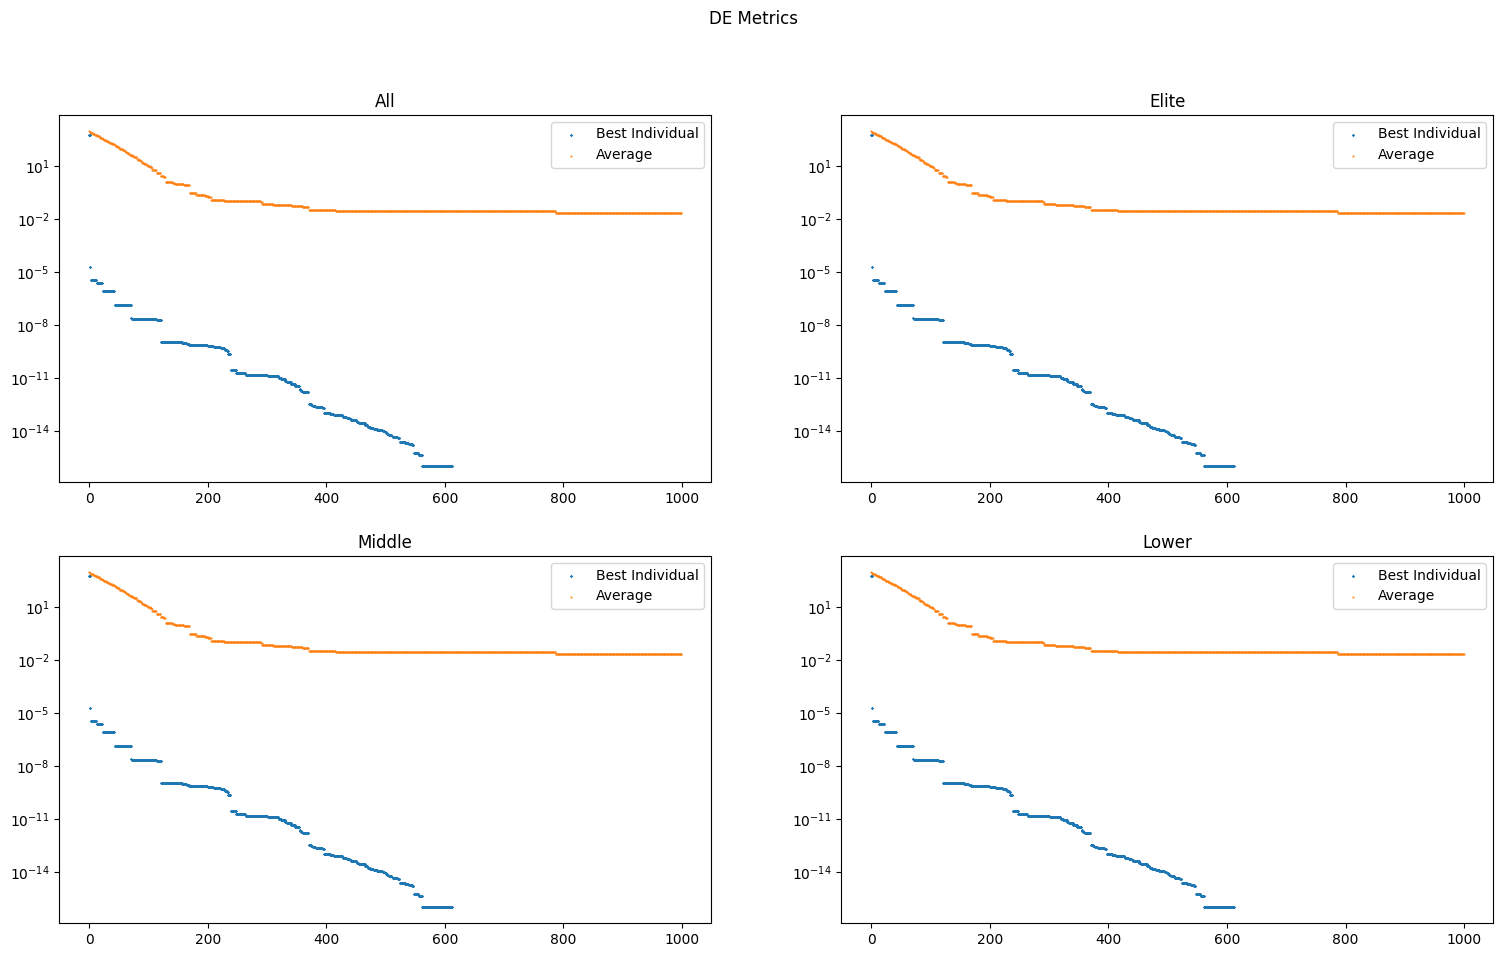

(array([ 4.69470693e-10, -1.26644944e-08, -8.44537733e-09, -1.30339785e-09,
         5.61385563e-09,  2.20131402e-08, -4.85316957e-09, -1.32486904e-09,
        -2.96232292e-08, -1.86519458e-09, -1.74107887e-08, -2.05236889e-08,
        -3.48640455e-08,  7.64351624e-09, -1.95154647e-08,  1.31709321e-08,
         2.54832813e-08, -2.69510341e-08, -1.24938712e-08, -4.42366126e-08,
         4.54653832e-08, -8.96607552e-10, -1.16330477e-09,  1.99604505e-08,
         5.90573139e-09,  4.79880301e-08,  4.25344405e-08, -1.41517261e-08,
        -1.12956217e-08, -5.42928189e-08]),
 0.0)

In [393]:
def griewangk(x: np.ndarray):
    cost = 1/4000 * np.sum(np.apply_along_axis(lambda y: y**2, 0, x))
    prod = 1
    for i in range(x.shape[0]):
        prod *= np.cos(x[i] / np.sqrt(i + 1))
    return cost - prod + 1

for i in range(30):
    np.random.seed(i)
    metric_8 = MetricCollector(name="griewangk", run_id=i)
    d = 30
    bounds = [(-600, 600) for _ in range(d)]
    popsize=40
    n_iters=1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = de_da(
        f=griewangk,
        popsize=popsize,
        bounds=bounds,
        exact_gradient_prob=0.01,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        differential_factor=0.5,
        crossover_prob=0.01,
        elitism_ratio=0.8,
        n_iter=n_iters,
        metric=metric_8,
        T=5000,
        seed=i
    )
    metric_8.save_results()
metric_8.compile_graphs()
res

Iteration 0: Best: 1.1535730904427648, T: 0.0, [2.43381491 3.74461389 3.2724512  4.45639648 3.61488046 5.36440463
 2.66076    2.95463824 1.6465894  4.24297536 3.09777435 2.73623108
 3.50208344 1.54461482 3.54928717 3.79268223 2.5799079  3.34464714
 2.86735311 1.55777716 3.91362488 2.88304604 2.73047595 5.13200837
 2.46412787 1.41657533 2.52165892 2.29230093 1.99503778 3.81671377
 2.32629164 3.04400821 2.19180041 3.06727555 2.69691499 5.98261546
 1.66299787 1.15357309 4.32087371 2.68268422]
Iteration 100: Best: 6.305893850019443e-08, T: 0.0, [6.30589385e-08 1.54952157e-06 1.11175938e-06 1.39532618e-07
 5.64398444e-07 1.00266109e-07 2.84294102e-07 1.69034349e-07
 1.51919403e-06 2.34616631e-07 1.91669082e-06 1.40545192e-07
 6.81089663e-07 5.90271382e-07 1.27714927e-07 3.72181309e-07
 3.49349719e-07 3.47636087e-07 1.96467313e-07 4.00245933e-07
 4.56176171e-07 9.96092917e-08 1.11161273e-06 1.55787449e-06
 3.66332096e-07 3.77752398e-07 2.60097827e-07 1.32370084e-07
 8.96361754e-07 1.15478040

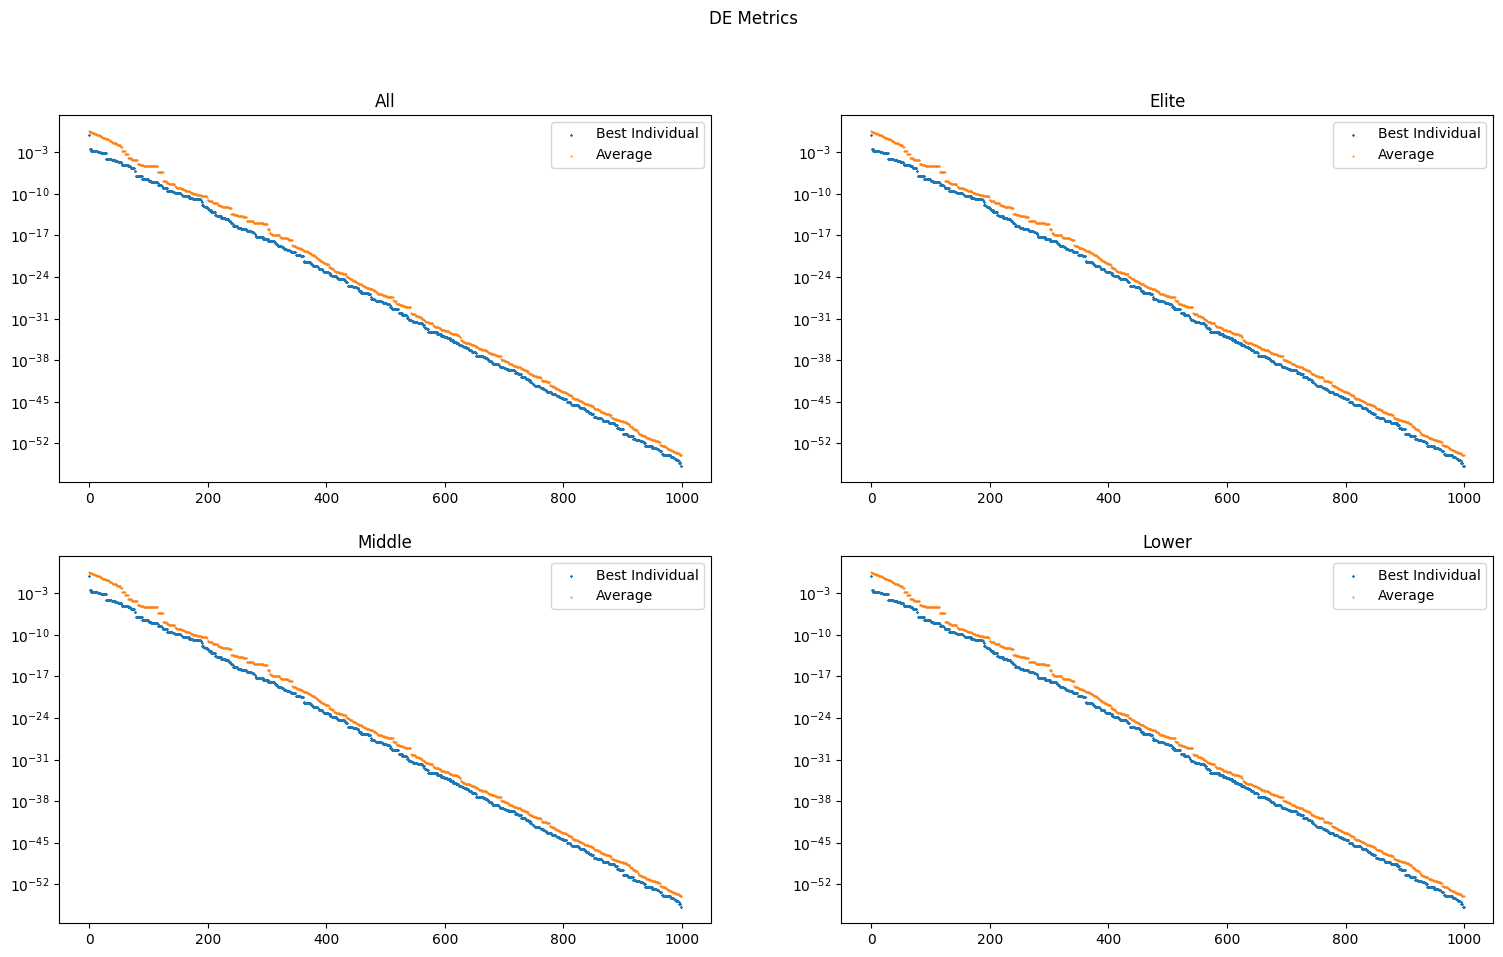

(array([-9.94823781e-57,  5.37555590e-29, -5.01242205e-20,  5.23806488e-15,
         1.58108053e-12, -3.00098310e-10, -1.56999453e-09,  5.55250750e-08,
        -3.33332259e-07,  1.29780928e-06,  4.69857837e-06, -1.52373403e-05,
         9.98827516e-06,  6.46172368e-05,  6.59450569e-05, -2.33575977e-04,
         3.47887112e-04, -7.29122087e-04,  3.59835087e-04, -2.00162420e-04,
        -1.37189694e-03, -2.24352232e-03, -1.07093225e-03,  1.16022431e-03,
         3.63902309e-03, -2.95540217e-04, -5.15597086e-03,  7.15286810e-03,
        -6.03050395e-03, -1.22487622e-02]),
 1.8794772804059731e-56)

In [394]:
def pow_sum(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += np.abs(x[i]) ** (i + 1)
    return cost

for i in range(30):
    np.random.seed(i)
    metric_9 = MetricCollector(name="pow_sum", run_id=i)
    d = 30
    bounds = [(-1, 1) for _ in range(d)]
    n_iters = 1000
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = de_da(
        f=pow_sum,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_prob=0.01,
        differential_factor=0.5,
        crossover_prob=0.1,
        n_iter=n_iters,
        metric=metric_9,
        T=0,
        seed=i
    )
    metric_9.save_results()
metric_9.compile_graphs()
res

In [423]:
def ackley(x: np.ndarray):
    # ackley function
    cost = -20 * np.exp(-0.2 * np.sqrt(1/x.shape[0] * np.sum(np.apply_along_axis(lambda y: y**2, 0, x)))) - np.exp(1/x.shape[0] * np.sum(np.apply_along_axis(lambda y: np.cos(2 * np.pi * y), 0, x))) + 20 + np.exp(1)
    return cost

for i in range(30):
    np.random.seed(i)
    metric_14 = MetricCollector(name="ackley", run_id=i)
    d = 30
    bounds = [(-32.768, 32.768) for _ in range(d)]
    popsize=40
    n_iters=1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = de_da(
        f=ackley,
        popsize=popsize,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        bounds=bounds,
        exact_gradient_prob=0.01,
        differential_factor=0.5,
        crossover_prob=0.01,
        n_iter=n_iters,
        metric=metric_14,
        elitism_ratio=0.8,
        T=0,
        seed=i
    )
    metric_14.save_results()
metric_14.compile_graphs()
res

Iteration 0: Best: 20.739353060582147, T: 5000.0, [21.26919699 21.11777916 21.30899701 21.49511947 21.48003222 21.3986032
 21.26773731 21.25964663 21.15325764 21.35234576 21.01030599 21.18969774
 21.2516711  21.41887873 21.34182818 21.53386595 21.1186111  21.46830872
 21.08708052 21.19672906 21.48699728 21.12283591 20.96119395 21.33201278
 21.43949776 21.15803746 20.93336918 21.47046565 21.21160318 21.21856024
 21.14803671 21.5170551  21.09076782 21.26357049 21.39462591 21.73974887
 20.88942985 20.73935306 21.36600225 21.47291264]
Iteration 100: Best: 12.867140732485804, T: 5.781443541885687, [12.86714073 15.46538822 14.96660922 16.96510196 15.33372748 19.07665403
 15.11742885 14.77696108 16.53412581 17.87500506 15.49619509 17.04467689
 16.614715   14.70113887 17.49491929 14.66535771 17.89964333 15.44434419
 14.50916637 17.88779562 16.65134623 13.76134938 16.68930767 15.67720408
 17.04545351 16.93881167 15.1849387  17.27940759 14.47996921 17.32284372
 15.91058958 18.42353577 18.1143340

KeyboardInterrupt: 

In [417]:
def rastrigin(x: np.ndarray):
    return 10 * x.shape[0] + np.sum(np.apply_along_axis(lambda y: y**2 - 10 * np.cos(2 * np.pi * y), 0, x))

for i in range(30):
    np.random.seed(i)
    metric_15 = MetricCollector(name="rastrigin", run_id=i)
    d = 30
    bounds = [(-600, 600) for _ in range(d)]
    popsize = 40
    n_iters=1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = de_da(
        f=rastrigin,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_prob=0.01,
        differential_factor=0.55,
        crossover_prob=0.01,
        n_iter=n_iters,
        metric=metric_15,
        T=500,
        visit=2.62,
        elitism_ratio=0.8,
        max_explore_nodes=0,
        iter_to_explore=20,
        seed=i
    )
    metric_15.save_results()

metric_15.compile_graphs()
res

Iteration 0: Best: 2364036.723388786, T: 500.0, [2741651.19035693 3224745.56515447 3373063.28933066 3745510.02062109
 3950581.44211329 5474133.8463895  3785514.13058083 3174574.90727967
 3412549.57518863 4021407.86317406 3390525.67638237 3409538.63995841
 3319107.38268503 3554270.4749944  3718460.05071668 4448822.56646395
 3081458.05442985 3779404.8390794  3049121.42563692 3651093.01138659
 4056288.20994353 3097844.5770656  3100036.59393098 3992869.28972904
 3497548.94594597 2997224.5121514  3253627.87104868 3651961.72955782
 3458406.65422411 4134295.57485163 3239279.19301849 3968132.29175411
 3056078.61475337 4089052.42889581 3386749.81301931 4703881.10001496
 3410803.6719389  2364036.72338879 4296516.25628288 4157344.24308546]
Iteration 100: Best: 1851.5799121495654, T: 0.5781443541885687, [  1851.57991215   5487.61340071  97727.99850324   3274.22835056
   1965.17235711   2385.5920353   24809.90552759   3911.89567621
   3628.67295804 118467.55850966  31031.9724757    2977.24616647
  

KeyboardInterrupt: 

(0.9980038377944496, [-31.978333625355454, -31.978335021953196])
Iteration 0: Best: 33.130643968857505, T: 100.0, [260.03278362 499.99876142 499.98126841 499.99429141 469.06432324
 499.86690318 499.99950523 499.76406177 499.99907679 499.86104944
 471.16642128 499.99941843 499.32782058 496.74334538 499.66121845
 499.95567807  33.13064397 499.99813567 499.99272548 499.91058509
 499.99847704 499.99104538 499.99335813 497.32121036 499.9936424
 499.99913676 430.52380423  45.8509965  499.99593467 498.02408503
 497.88579494 497.96489112 499.99966893 469.68820717 472.25110058
 496.2142123  499.99868702 499.99679315 499.99879887 118.17414877]
Iteration 100: Best: 0.9980038377944496, T: 0.11562887083771374, [0.99800384 0.99800384 0.99800384 0.99800384 0.99800384 0.99800384
 0.99800384 0.99800384 0.99800384 0.99800384 0.99800384 0.99800384
 0.99800384 0.99800384 0.99800384 0.99800384 0.99800384 0.99800384
 0.99800384 0.99800384 0.99800384 0.99800384 0.99800384 0.99800384
 0.99800384 0.99800384 0.

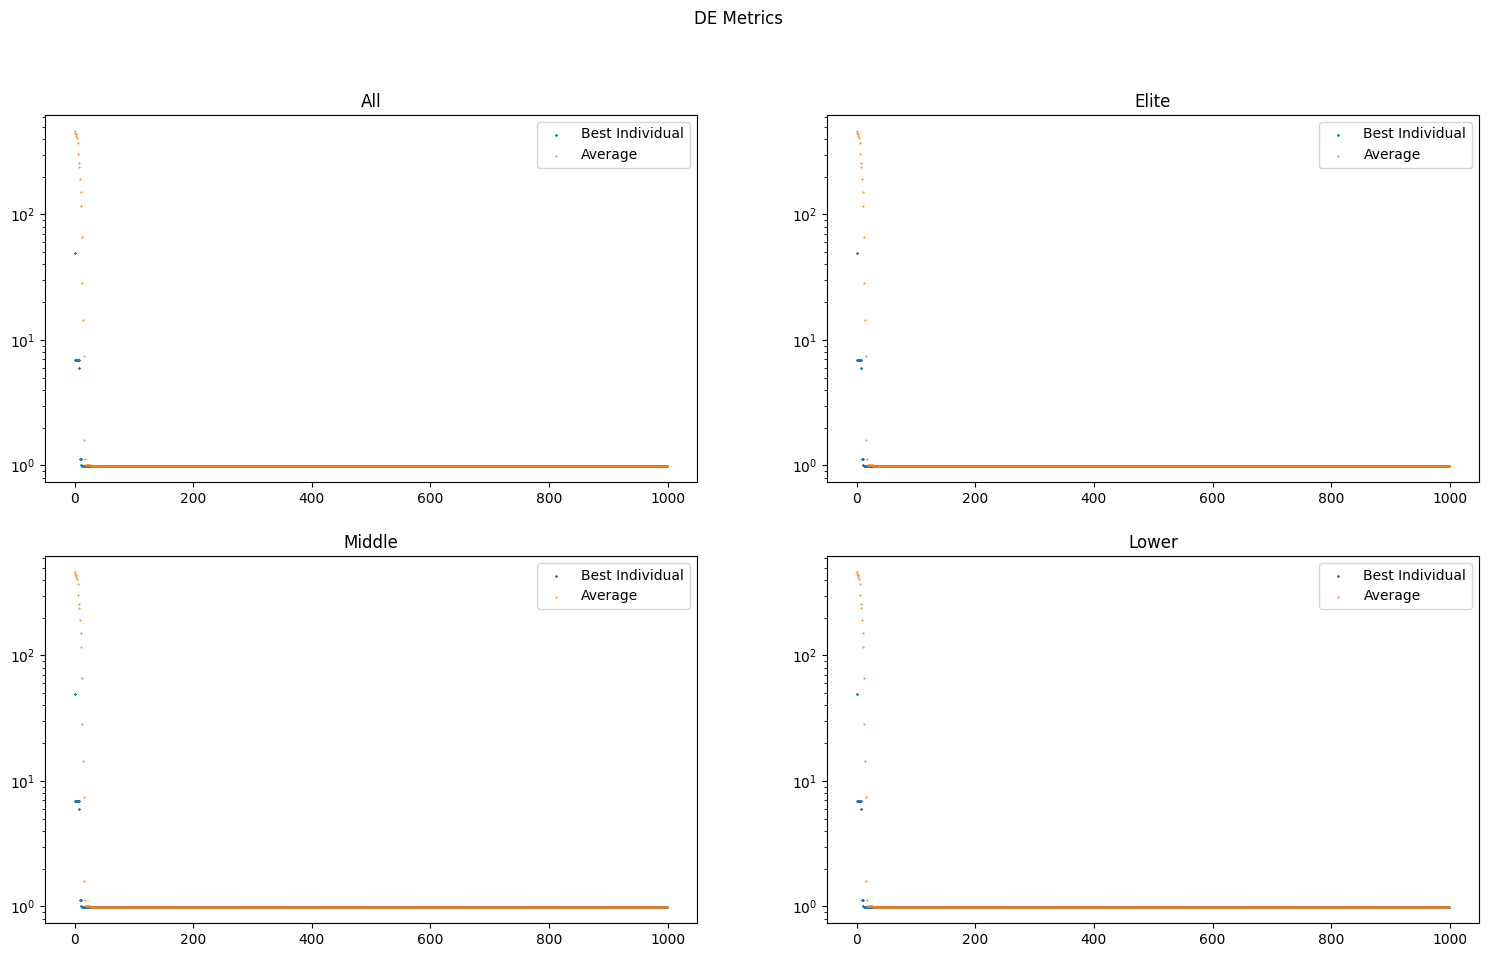

(array([-31.97833495, -31.97833356]), 0.9980038377944496)

In [397]:
for i in range(30):
    np.random.seed(i)
    metric_dejong_5 = MetricCollector(name="dejong_5", run_id=i)
    funcs = bf.DeJong5()
    print(funcs.minimum())
    bounds = [(-65.536, 65.636), (-65.536, 65.636)]
    popsize=40
    n_iters=1000
    sampler = stats.qmc.LatinHypercube(d=2, seed=i)
    res = de_da(
        f=funcs,
        popsize=popsize,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        bounds=bounds,
        exact_gradient_prob=0.00,
        differential_factor=0.5,
        crossover_prob=0.0,
        n_iter=n_iters,
        metric=metric_dejong_5,
        T=100,
        vtr=0.999,
        seed=i
    )
    metric_dejong_5.save_results()
metric_dejong_5.compile_graphs()
res

Iteration 0: Best: 79, T: 0.0, [106  97  97 116 101 113 121 110 100 112 105 131 102 109 101 109 112 116
 108 109 101 112 116  90 105 117  99 108 125 109 124  79 109 123 126 105
 121 111 106 108]
Iteration 100: Best: 0, T: 0.0, [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Iteration 200: Best: 0, T: 0.0, [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Iteration 300: Best: 0, T: 0.0, [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Iteration 400: Best: 0, T: 0.0, [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Iteration 500: Best: 0, T: 0.0, [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Iteration 600: Best: 0, T: 0.0, [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Iteration 700: Best: 0, T: 0.0, [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


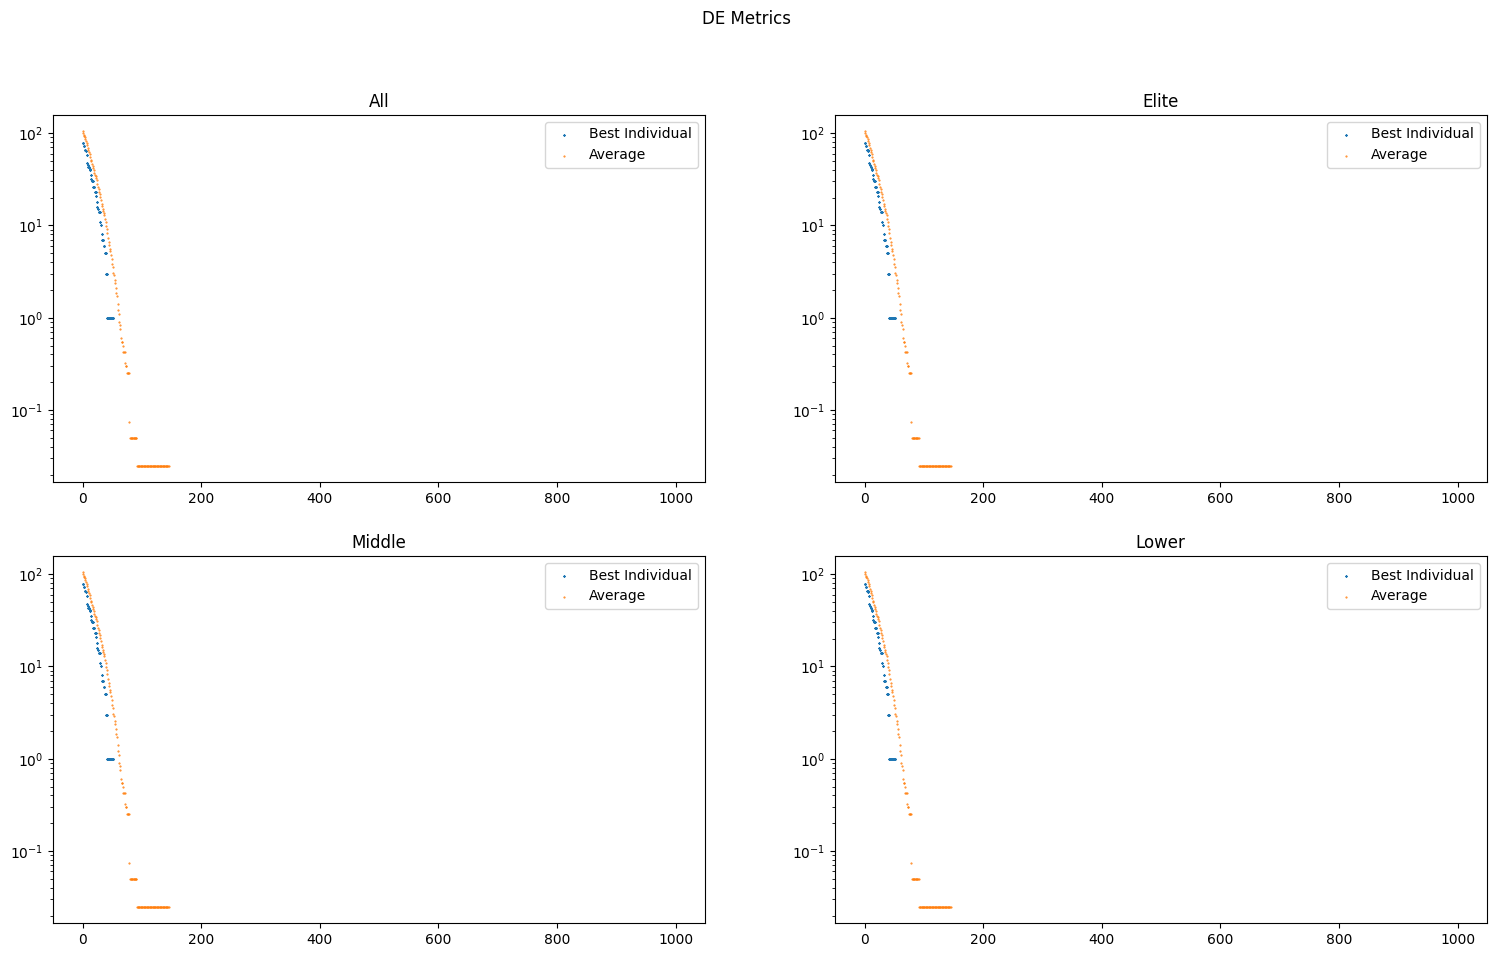

(array([-3.5       , -3.5       , -3.3645786 , -3.40040909, -3.5       ,
        -3.00195682, -3.36287498, -3.49072931, -3.5       , -3.41248861,
        -3.35710845, -3.45661584, -3.22795544, -3.5       , -3.36838465,
        -3.22543338, -3.5       , -3.5       , -3.5       , -3.5       ,
        -3.5       , -3.48901375, -3.5       , -3.34099267, -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.5       , -3.5       ]),
 0)

In [398]:
for i in range(30):
    np.random.seed(i)
    dejong_3_func = lambda x: bf.DeJong3(n_dimensions=30)(x) + 120
    metric_dejong_3 = MetricCollector(name="dejong_3", run_id=i)
    dejong_3_stub = lambda x: dejong_3_func(x)
    bounds = [(-3.5, 3.8) for i in range(30)]
    popsize=40
    n_iters=1000
    sampler = stats.qmc.LatinHypercube(d=30, seed=i)
    res = de_da(
        f=dejong_3_stub,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_prob=0.0,
        differential_factor=0.5,
        crossover_prob=0.1,
        n_iter=n_iters,
        metric=metric_dejong_3,
        T=0,
        seed=i
    )
    metric_dejong_3.save_results()
metric_dejong_3.compile_graphs()
res